# Сборный проект - 2

**Описание проекта**

Стартап, который продаёт продукты питания, планирует разобраться в поведении пользователей мобильного приложения.

**Цель проекта**

Изучить воронку продаж и исследовать результаты A/A/B-эксперимента по изменению шрифтов в приложении.

**Ход исследования**

Исследование пройдёт в пять этапов:
1. Обзор данных
2. Подготовка данных
3. Изучение и проверка данных
4. Анализ воронки событий
5. Анализ результатов эксперимента

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие.  
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Шаг 1. Обзор данных

In [ ]:
import pandas as pd # импортируем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats as st
import math as mth
from plotly import graph_objects as go

In [ ]:
pd.set_option('display.max_columns', None) # код для того, чтобы отображались все столбцы датафрейма при выводе их на экран
pd.set_option('max_colwidth', 200) # код для того, чтобы столбцы отображались полностью

In [ ]:
logs = pd.read_csv('/datasets/logs_exp.csv',sep= '\t') # откроем файл '/datasets/logs_exp.csv' и сохраним его в переменную logs
logs.head() # отобразим первые 5 строк датафрейма

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Шаг 2. Подготовка данных

### Шаг 2.1. Замените названия столбцов на удобные для вас.

In [ ]:
logs.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']
logs.head()

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Шаг 2.2. Проверьте пропуски и типы данных. Откорректируйте, если нужно.

In [ ]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Видим, что пропусков в столбцах датафрейма logs нет.
В столбце event_timestamp указано время в формате unix time, тип данных указан 'int64'. Оставим данный столбец без изменений, так как мы добавим столбцы с привычным временем в следующем задании.

Проверим датафрейм на наличие явных дубликатов:

In [ ]:
logs.duplicated().sum()

413

Видим, что есть 413 строк с явными дубликатами.

In [ ]:
print(f'Количество дубликатов от общего числа строк составляет: {logs.duplicated().sum()/len(logs):.2%}')

Количество дубликатов от общего числа строк составляет: 0.17%


Удалим явные дубликаты:

In [ ]:
logs = logs.drop_duplicates()

In [ ]:
logs.duplicated().sum()

0

### Шаг 2.3. Добавьте столбец даты и времени, а также отдельный столбец дат.

In [ ]:
logs['datetime'] = pd.to_datetime(logs['event_timestamp'], unit='s')
logs.head()

,event_name,device_id_hash,event_timestamp,exp_id,datetime
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


In [ ]:
logs['date'] = logs['datetime'].dt.date
logs.head()

,event_name,device_id_hash,event_timestamp,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [ ]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   datetime         243713 non-null  datetime64[ns]
 5   date             243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


**Вывод к шагу 2.**

В датафрейме logs 4 столбца. Изменили названия столбцов на привычный змеиный регистр: 'event_name', 'device_id_hash', 'event_timestamp', 'exp_id'. Обнаружили, что пропусков в датафрейме нет. Зато есть явные дубликаты в количестве 413 строк, которые мы удалили. Добавили два столбца 'datetime' и 'date' с датой и временем и только с датой, соответственно.

## Шаг 3. Изучение и проверка данных



### Шаг 3.1. Сколько всего событий в логе?

In [ ]:
print(f'В логе {logs.shape[0]} событий')

В логе 243713 событий


### Шаг 3.2. Сколько всего пользователей в логе?

In [ ]:
print(f"В логе {len(logs['device_id_hash'].unique())} пользователей")

В логе 7551 пользователей


### Шаг 3.3. Сколько в среднем событий приходится на пользователя?

In [ ]:
print(f"В среднем на пользователя приходится {len(logs)/len(logs['device_id_hash'].unique()):.2f} события")

В среднем на пользователя приходится 32.28 события


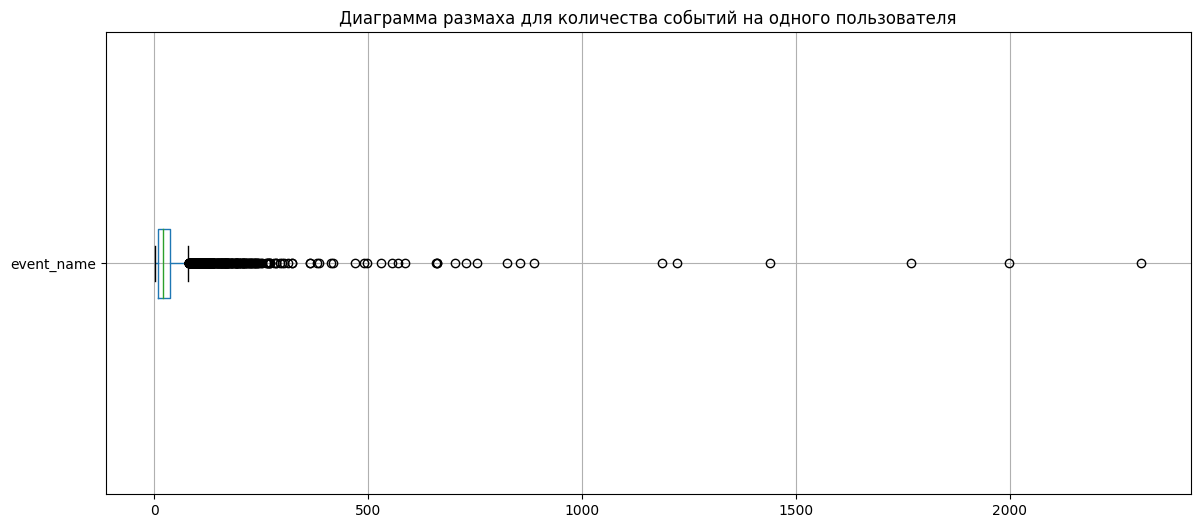

In [ ]:
plt.figure(figsize=(14, 6))
logs.groupby('device_id_hash').agg({'event_name':'count'}).boxplot(column='event_name',vert=False)
plt.title('Диаграмма размаха для количества событий на одного пользователя');

In [ ]:
logs.groupby('device_id_hash').agg({'event_name':'count'})['event_name'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

Видим, что в количестве событий на одного пользователя есть выбросы. Поэтому в данном случае более подходящим параметром будет не среднее, а медиана. Медианное значение количества событий на одного пользователя составляет 20 событий на пользователя.

### Шаг 3.4.  Данными за какой период вы располагаете?
**Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?**

In [ ]:
print(f"Минимальная дата - {logs['date'].min()}")
print(f"Максимальная дата - {logs['date'].max()}")

Минимальная дата - 2019-07-25
Максимальная дата - 2019-08-07


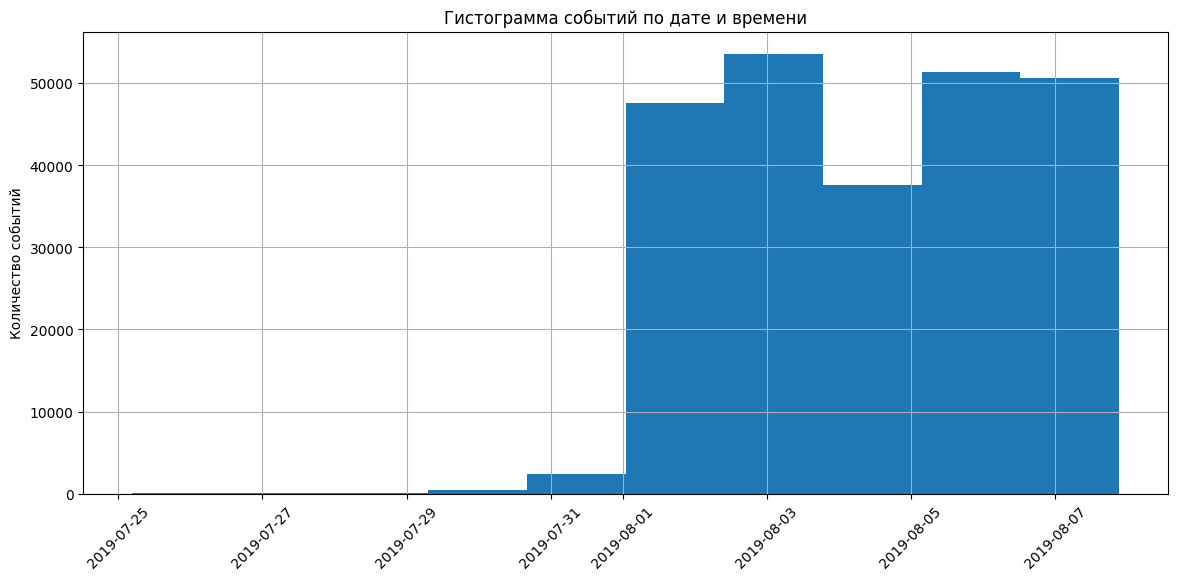

In [ ]:
plt.figure(figsize=(14, 6))
logs['datetime'].hist()
# Rotating X-axis labels
plt.xticks(rotation = 45)
plt.title('Гистограмма событий по дате и времени')
plt.ylabel("Количество событий");

По гистограмме видим, что данных за июль значительно меньше, чем данных за август. Мы не можем утверждать, что у нас одинаково полные данные за весь период.

Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». По гистограмме видим, что с 2019-08-01 данные полные, поэтому отбросим более старые данные.  
На самом деле располагаем данными с 2019-08-01 по 2019-08-07.

In [ ]:
filtered_logs = logs[logs['datetime'] >= '2019-08-01']
filtered_logs.head()

,event_name,device_id_hash,event_timestamp,exp_id,datetime,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


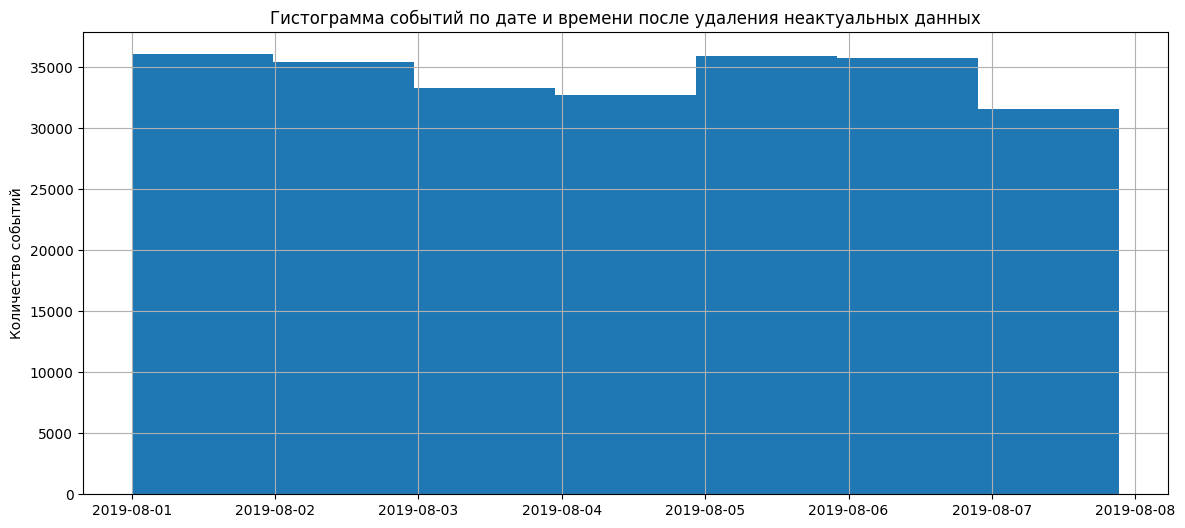

In [ ]:
plt.figure(figsize=(14, 6))
filtered_logs['datetime'].hist(bins=7)
plt.title('Гистограмма событий по дате и времени после удаления неактуальных данных')
plt.ylabel("Количество событий");

### Шаг 3.5. Много ли событий и пользователей вы потеряли, отбросив старые данные?

Отобразим последние 5 строчек удалённых логов

In [ ]:
discarded_logs = logs[logs['datetime'] < '2019-08-01']
discarded_logs.tail()

,event_name,device_id_hash,event_timestamp,exp_id,datetime,date
2823,OffersScreenAppear,2413191300976302222,1564617295,247,2019-07-31 23:54:55,2019-07-31
2824,MainScreenAppear,5505110279185484837,1564617450,247,2019-07-31 23:57:30,2019-07-31
2825,MainScreenAppear,5505110279185484837,1564617462,247,2019-07-31 23:57:42,2019-07-31
2826,MainScreenAppear,5505110279185484837,1564617472,247,2019-07-31 23:57:52,2019-07-31
2827,MainScreenAppear,2413191300976302222,1564617599,247,2019-07-31 23:59:59,2019-07-31


In [ ]:
print(f"В датафрейме logs {len(logs['device_id_hash'].unique())} уникальных пользователей.")

В датафрейме logs 7551 уникальных пользователей.


In [ ]:
print(f"В датафрейме filtered_logs {len(filtered_logs['device_id_hash'].unique())} уникальных пользователей.")

В датафрейме filtered_logs 7534 уникальных пользователей.


In [ ]:
print(f"Потери уникальных пользователей после удаления старых данных составляют: \
{len(logs['device_id_hash'].unique()) - len(filtered_logs['device_id_hash'].unique())} \
пользователей.")

Потери уникальных пользователей после удаления старых данных составляют: 17 пользователей.


In [ ]:
print(f"Относителные потери уникальных пользователей после удаления старых данных: \
{(len(logs['device_id_hash'].unique())-len(filtered_logs['device_id_hash'].unique()))/len(logs['device_id_hash'].unique()):.2%}\
")

Относителные потери уникальных пользователей после удаления старых данных: 0.23%


In [ ]:
print(f"В датафрейме logs {len(logs)} событий.")

В датафрейме logs 243713 событий.


In [ ]:
print(f"В датафрейме filtered_logs {len(filtered_logs)} событий.")

В датафрейме filtered_logs 240887 событий.


In [ ]:
print(f"После удаления старых данных потеряли \
{len(logs) - len(filtered_logs)} \
события")

После удаления старых данных потеряли 2826 события


In [ ]:
print(f"Относительные потери событий после удаления старых данных: \
{(len(logs) - len(filtered_logs)) / len(logs):.2%} \
")

Относительные потери событий после удаления старых данных: 1.16% 


### Шаг 3.6. Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [ ]:
if len(filtered_logs['exp_id'].unique()) == 3:
    print("В отфильтованных данных есть пользователи из всех трёх экспериментальных групп.")
else:
    print("в отфильтованных данных нет пользователей из всех трёх экспериментальных групп.")

В отфильтованных данных есть пользователи из всех трёх экспериментальных групп.


Также проверим, есть ли пользователи, которые присутствуют одновременно в группе 246 и 247.

In [ ]:
device_in_both_groups_246_and_247 = (
    pd.DataFrame(filtered_logs.query('exp_id == 246')['device_id_hash'].unique())
    .merge(pd.DataFrame(filtered_logs.query('exp_id == 247')['device_id_hash'].unique()))
)
device_in_both_groups_246_and_247.shape[0]

0

Проверим, есть ли пользователи, которые присутствуют одновременно в группе 246 и 248.

In [ ]:
device_in_both_groups_246_and_248 = (
    pd.DataFrame(filtered_logs.query('exp_id == 246')['device_id_hash'].unique())
    .merge(pd.DataFrame(filtered_logs.query('exp_id == 248')['device_id_hash'].unique()))
)
device_in_both_groups_246_and_248.shape[0]

0

Проверим, есть ли пользователи, которые присутствуют одновременно в группе 247 и 248.

In [ ]:
device_in_both_groups_247_and_248 = (
    pd.DataFrame(filtered_logs.query('exp_id == 247')['device_id_hash'].unique())
    .merge(pd.DataFrame(filtered_logs.query('exp_id == 248')['device_id_hash'].unique()))
)
device_in_both_groups_247_and_248.shape[0]

0

Пользователей, которые присутствуют одновременно в нескольких группах, в датафрейме filtered_logs нет.

**Вывод к шагу 3**

Выяснили, что в логе 243713 событий и 7551 пользователей.   
По гистограмме даты и времени событий выяснили, что только с 2019-08-01 данные полные, поэтому отбросим более старые данные. На самом деле располагаем данными с 2019-08-01 по 2019-08-07.  
Отбросив старые данные, мы потеряли 2826 событий и 17 пользователей.
Убедились, что в отфильтрованных данных остались пользователи из всех трёх экспериментальных групп, а также в том, что нет пользователей, которые одновременно присутствуют в разных группах.  


## Шаг 4. Анализ воронки событий

### Шаг 4.1. Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [ ]:
filtered_logs['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Видим, что в логах всего 5 событий: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial. Самое популярное событие - MainScreenAppear, оно встречается 117328 раз.

### Шаг 4.2. Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [ ]:
users_in_event = (
    filtered_logs.groupby('event_name',as_index=False).agg({'device_id_hash':'nunique'})\
    .sort_values(by='device_id_hash',ascending=False)
)
users_in_event['percent_of_all_unique_devices,%'] = round(users_in_event['device_id_hash']*100/\
len(filtered_logs['device_id_hash'].unique()),2)
users_in_event

,event_name,device_id_hash,"percent_of_all_unique_devices,%"
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Посчитали, сколько уникальных пользователей совершили каждое из событий. Также отобразили процент пользователей, совершивших событие, к общему числу пользователей в колонке 'percent_of_all_unique_devices,%'.

### Шаг 4.3. Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

События могут происходить в следующем порядке по убыванию процентов в столбце 'percent_of_all_unique_devices,%': MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful. Tutorial  может появляться после любой из страниц, которые мы указали ранее, у нас нет данных об этом.

### Шаг 4.4. По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).
**То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.**

In [ ]:
# удалим строку с со значением 'Tutorial' в столбце event_name
users_in_event_filtered = users_in_event.query('event_name != "Tutorial"').reset_index(drop=True)
users_in_event_filtered

,event_name,device_id_hash,"percent_of_all_unique_devices,%"
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97


In [ ]:
# создадим столбец 'previous_device_id_hash', чтобы посчитать далее конверсию из одного события в другое
users_in_event_filtered['previous_device_id_hash'] = users_in_event_filtered['device_id_hash']\
.shift(1,fill_value=len(filtered_logs['device_id_hash'].unique()))
users_in_event_filtered

,event_name,device_id_hash,"percent_of_all_unique_devices,%",previous_device_id_hash
0,MainScreenAppear,7419,98.47,7534
1,OffersScreenAppear,4593,60.96,7419
2,CartScreenAppear,3734,49.56,4593
3,PaymentScreenSuccessful,3539,46.97,3734


In [ ]:
# В столбце 'conversion,%' посчитаем, какая доля пользователей проходит на следующий шаг воронки
# (от числа пользователей на предыдущем шаге)
users_in_event_filtered['conversion,%'] = round(users_in_event_filtered['device_id_hash']*100/\
                                              users_in_event_filtered['previous_device_id_hash'],2)
users_in_event_filtered

,event_name,device_id_hash,"percent_of_all_unique_devices,%",previous_device_id_hash,"conversion,%"
0,MainScreenAppear,7419,98.47,7534,98.47
1,OffersScreenAppear,4593,60.96,7419,61.91
2,CartScreenAppear,3734,49.56,4593,81.30
3,PaymentScreenSuccessful,3539,46.97,3734,94.78


По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). Конверсия события 'MainScreenAppear' от общего числа уникальных пользователей - 98.47%; конверсия 'OffersScreenAppear' от 'MainScreenAppear' - 61.91%; конверсия события 'CartScreenAppear' от 'OffersScreenAppear' - 81.30%; конверсия события 'PaymentScreenSuccessful' от события 'OffersScreenAppear' - 94.78%.

### Шаг 4.5. На каком шаге теряете больше всего пользователей?

In [ ]:
# в столбце 'difference' отобразим число человек, которые мы потеряли с предыдущего шага
pd.concat([users_in_event_filtered['event_name'],
           pd.Series(users_in_event_filtered['previous_device_id_hash']-users_in_event_filtered['device_id_hash'],
                     name='difference')], axis=1)

,event_name,difference
0,MainScreenAppear,115
1,OffersScreenAppear,2826
2,CartScreenAppear,859
3,PaymentScreenSuccessful,195


In [ ]:
print(f"""На шаге {users_in_event_filtered['event_name'][(users_in_event_filtered['previous_device_id_hash']-
users_in_event_filtered['device_id_hash']).argmax()]} теряем больше всего пользователей.""")

На шаге OffersScreenAppear теряем больше всего пользователей.


### Шаг 4.6. Какая доля пользователей доходит от первого события до оплаты?

In [ ]:
print(f"{users_in_event_filtered.loc[3,'device_id_hash']/users_in_event_filtered.loc[0,'device_id_hash']:.2%} \
пользователей доходит от первого события до оплаты.")

47.70% пользователей доходит от первого события до оплаты.


In [ ]:
fig = go.Figure(go.Funnel(
    y = ["AllUsers", users_in_event_filtered.loc[0,'event_name'],
         users_in_event_filtered.loc[1,'event_name'], users_in_event_filtered.loc[2,'event_name'],
         users_in_event_filtered.loc[3,'event_name']],
    x = [users_in_event_filtered.loc[0,'previous_device_id_hash'], users_in_event_filtered.loc[0,'device_id_hash'],
         users_in_event_filtered.loc[1,'device_id_hash'], users_in_event_filtered.loc[2,'device_id_hash'],
         users_in_event_filtered.loc[3,'device_id_hash']],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )

fig.update_layout(title_text='График воронки', title_x=0.5)
fig.show()

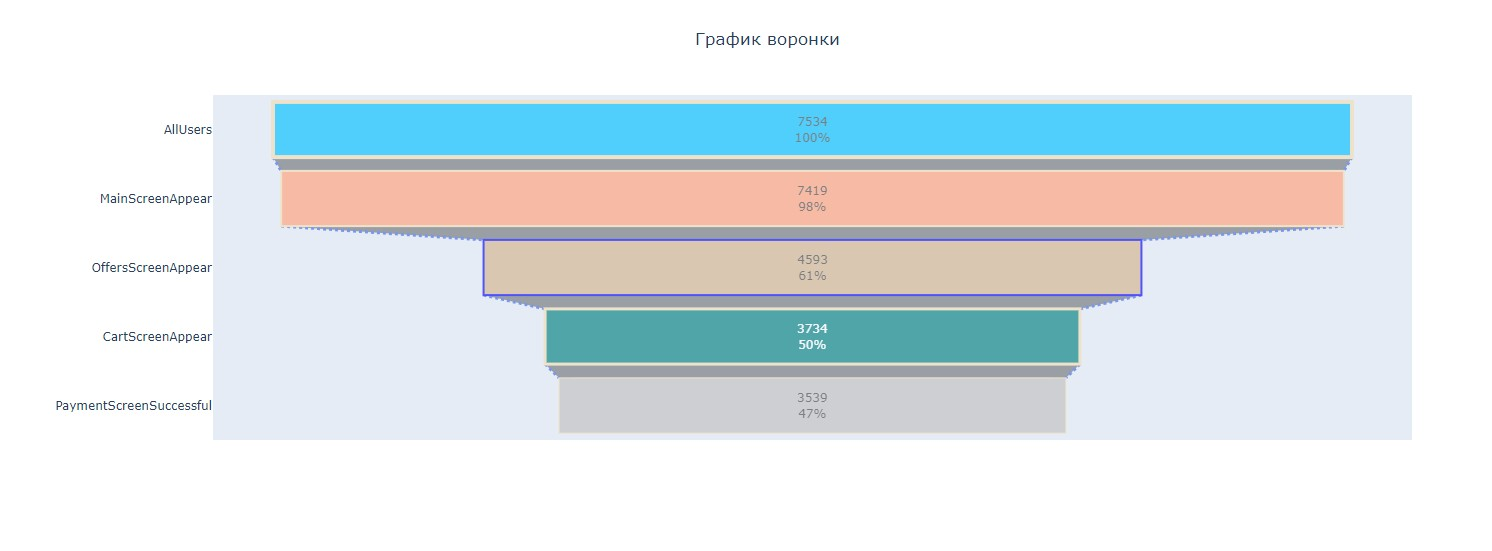

**Вывод к главе 4**  



- Выяснили, что в логах всего 5 событий: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial. Самое популярное событие - MainScreenAppear, оно встречается 117328 раз.  
- Посчитали, сколько уникальных пользователей совершили каждое из событий. Также отобразили процент пользователей, совершивших событие, к общему числу пользователей в колонке 'percent_of_all_unique_devices,%'.
- События могут происходить в следующем порядке по убыванию процентов в столбце 'percent_of_all_unique_devices,%': MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful. Tutorial может появляться после любой из страниц, которые мы указали ранее, у нас нет данных об этом. Поэтому мы не будем далее в воронке рассматривать это событие.
- Далее по воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). Конверсия события 'MainScreenAppear' от общего числа уникальных пользователей - 98.47%; конверсия 'OffersScreenAppear' от 'MainScreenAppear' - 61.91%; конверсия события 'CartScreenAppear' от 'OffersScreenAppear' - 81.30%; конверсия события 'PaymentScreenSuccessful' от события 'OffersScreenAppear' - 94.78%.  
- Выяснили, что на шаге OffersScreenAppear теряем больше всего пользователей.
- 47.70% пользователей доходит от первого события до оплаты.

## Шаг 5. Анализ результатов эксперимента

### Шаг 5.1. Сколько пользователей в каждой экспериментальной группе?

Преобразуем для выполнения этого задания датафрейм filtered_logs в new_filtered_logs. Уберём из столбца 'event_name' событие 'Tutorial', так как мы не знаем, из какого другого события можно перейти на данную страницу.

In [ ]:
new_filtered_logs = filtered_logs.query('event_name != "Tutorial"')
new_filtered_logs['event_name'].value_counts() # Проверим удаление событий 'Tutorial'

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Name: event_name, dtype: int64

In [ ]:
new_filtered_logs.groupby('exp_id', as_index=False).agg({'device_id_hash':'nunique'})

,exp_id,device_id_hash
0,246,2483
1,247,2512
2,248,2535


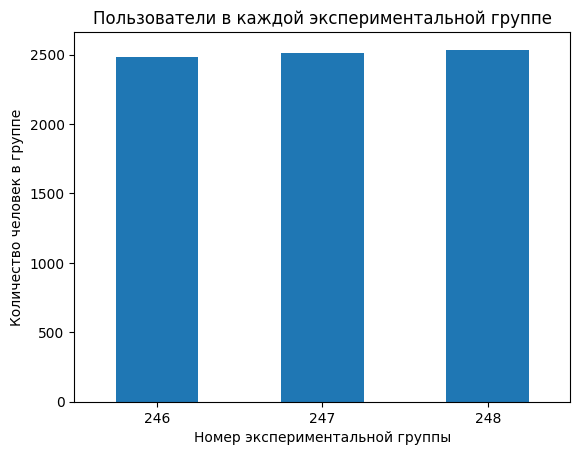

In [ ]:
(
    new_filtered_logs
    .groupby('exp_id', as_index=False)
    .agg({'device_id_hash':'nunique'})
    .plot(x='exp_id',y='device_id_hash',kind='bar', legend=None)
)
plt.xticks(rotation = 0)
plt.title('Пользователи в каждой экспериментальной группе')
plt.xlabel('Номер экспериментальной группы')
plt.ylabel('Количество человек в группе');

Выяснили, что в группе 246 - 2483 пользователя; в группе 247 - 2512 пользователей; в группе 248 - 2535 пользователей.

### Шаг 5.2. Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

Создадим два датафрейма: с количеством уникальных пользователей в каждой группе для каждого события и с общим количеством уникальных пользователей в каждой группе.

In [ ]:
events_in_each_group = (
    new_filtered_logs.pivot_table(index='event_name', columns='exp_id',values='device_id_hash', aggfunc='nunique')
    .sort_values(by=246,ascending=False)#.reset_index()
)
events_in_each_group

exp_id,246,247,248
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181


In [ ]:
users_in_each_group = new_filtered_logs.pivot_table(columns='exp_id', values='device_id_hash',
                                                    aggfunc='nunique')#.reset_index()
users_in_each_group

exp_id,246,247,248
device_id_hash,2483,2512,2535


**Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.**

Нулевая гипотеза: Статистически значимых различий нет для доли пользователей, совершивших каждое из событий, к общему количеству человек в соответствующей группе.

Альтернативная гипотеза: Статистически значимые различия есть для доли пользователей, совершивших каждое из событий, к общему количеству человек в соответствующей группе.

Примем уровень статистической значимости, равный 5%.

In [ ]:
# создадим функцию для расчёта p_value при проверке гипотезы о равенстве долей

def hypothesis_about_equality_shares_between_2_events(group1, group2, alpha, count_hypothesis):

    # count_hypothesis - это количество гипотез, которые мы проверяем, подставляем это значение в формулу с поправкой Бонферрони

    success_one = events_in_each_group.loc[event,group1]
    success_two = events_in_each_group.loc[event,group2]

    trials_one = users_in_each_group.loc['device_id_hash',group1]
    trials_two = users_in_each_group.loc['device_id_hash',group2]

    # пропорция успехов в первой группе:
    p1 = success_one/trials_one

    # пропорция успехов во второй группе:
    p2 = success_two/trials_two

    # пропорция успехов при комбинации данных:о
    p_combined = (success_one + success_two) / (trials_one + trials_two)


    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_one + 1/trials_two))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    # Рассчитываем поправку Бонферрони. Необходимо поделить alpha на число гипотез, которое мы проверяем. Сейчас мы сравниваем
    # группы 246 и 247. Для сравнения пары групп используем 4 проверки по количеству событий (событий 4). Но нам интересен
    # результат проверки гипотез о равенстве долей для групп 246 и 247, 246 и 248, 247 и 248, а также для объединённой группы
    # 246 и 247 с группой 248 одновременно. Всего получается 4x4 проверки гипотез, то есть 16 проверок. Подставим в
    # count_hypothesis значение 16.

    bonferroni_alpha = alpha / count_hypothesis

    print(f'p-value при сравнения долей двух групп для события {event}: {p_value}')

    if p_value < bonferroni_alpha:
        print(f"Отвергаем нулевую гипотезу для сравнения двух групп, совершивших событие {event}")
    else:
        print(f"Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие {event}")

    print()

In [ ]:
for event in events_in_each_group.index:
    # используем функцию для расчёта p_value для сравнения каждого события для двух групп.
    hypothesis_about_equality_shares_between_2_events(246, 247, 0.05, 16)


p-value при сравнения долей двух групп для события MainScreenAppear: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие MainScreenAppear

p-value при сравнения долей двух групп для события OffersScreenAppear: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие OffersScreenAppear

p-value при сравнения долей двух групп для события CartScreenAppear: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие CartScreenAppear

p-value при сравнения долей двух групп для события PaymentScreenSuccessful: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие PaymentScreenSuccessful



Статистические критерии разницу между выборками 246 и 247 не находят.

Проверяя гипотезу для контрольных групп мы проверили, что механизм разбиения работает коррекно

### Шаг. 5.3. Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

**Выберем самое популярное событие.**

Выведем на экран датафрейм users_in_event_filtered. Именно из данного датафрейма найдём самое популярное событие.

In [ ]:
users_in_event_filtered

,event_name,device_id_hash,"percent_of_all_unique_devices,%",previous_device_id_hash,"conversion,%"
0,MainScreenAppear,7419,98.47,7534,98.47
1,OffersScreenAppear,4593,60.96,7419,61.91
2,CartScreenAppear,3734,49.56,4593,81.30
3,PaymentScreenSuccessful,3539,46.97,3734,94.78


In [ ]:
print(f"Самым популярным событием является {users_in_event_filtered.loc[0,'event_name']}.")

Самым популярным событием является MainScreenAppear.


**Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп.**

Выведем на экран датафрейм events_in_each_group. Именно из данного датафрейма найдём число пользователей, совершивших самое пулярное событие в каждой группе. Также в данном датафрейме указано число пользователей из каждой группы, совершивших другие события.

In [ ]:
events_in_each_group

exp_id,246,247,248
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181


In [ ]:
print(f"Отобразим число пользователей, совершивших событие {users_in_event_filtered.loc[0,'event_name']} в каждой из \
контрольных групп, то есть в группах 246 и 247.")
events_in_each_group.loc[users_in_event_filtered.loc[0,'event_name'],[246,247]]

Отобразим число пользователей, совершивших событие MainScreenAppear в каждой из контрольных групп, то есть в группах 246 и 247.


exp_id
246    2450
247    2476
Name: MainScreenAppear, dtype: int64

**Посчитаем долю пользователей, совершивших каждое из событий, к общему числу пользователей в данной группе.**

In [ ]:
share_in_each_group = events_in_each_group.copy()

for column in share_in_each_group.columns:
    share_in_each_group[[column]] = round(share_in_each_group[[column]].div(users_in_each_group.loc['device_id_hash',column]),4)

share_in_each_group

exp_id,246,247,248
event_name,,,
MainScreenAppear,0.9867,0.9857,0.9834
OffersScreenAppear,0.6210,0.6051,0.6039
CartScreenAppear,0.5099,0.4928,0.4852
PaymentScreenSuccessful,0.4833,0.4610,0.4659


In [ ]:
print(f"Отобразим долю пользователей, совершивших событие {users_in_event_filtered.loc[0,'event_name']} в каждой из \
контрольных групп к общему количеству пользователей в соответствующей группе, то есть в группах 246 и 247.")
share_in_each_group.loc[users_in_event_filtered.loc[0,'event_name'],[246,247]]

Отобразим долю пользователей, совершивших событие MainScreenAppear в каждой из контрольных групп к общему количеству пользователей в соответствующей группе, то есть в группах 246 и 247.


exp_id
246    0.9867
247    0.9857
Name: MainScreenAppear, dtype: float64

**Проверьте, будет ли отличие между контрольными группами статистически достоверным.**


На шаге 5.2 проверили, является ли отличие между контрольными группами, то есть группами 246 и 247, статистически достоверным. Выяснили, что отличие между группами 246 и 247 не является статистически достоверным.

**Можно ли сказать, что разбиение на группы работает корректно?**

Критерии успешного A/A-теста:
- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

Для первого и третьего пунктов важно, был ли преодалён порог в количестве необходимых пользователей в каждой группе, в нашем случае мы не знаем минимальный размер выборки. Поэтому данные пункты не учитываем в проверке. Для третьего пункта ранее (на шаге 5.2) выяснили, что отличие между группами 246 и 247 не является статистически достоверным.  
На шаге 3.6 совершили проверку для 4 пункта, выяснили, что нет пересечения пользователей в группах 246, 247 и 248.  
Критерии успешного  A/A-теста выполнены.

### Шаг 5.4. Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

Создадим объединённую группу 246 и 247 для последующей проверки.

In [ ]:
events_in_each_group['246_and_247'] = events_in_each_group[246] + events_in_each_group[247]
events_in_each_group

exp_id,246,247,248,246_and_247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


In [ ]:
users_in_each_group['246_and_247'] = users_in_each_group[246] + users_in_each_group[247]
users_in_each_group

exp_id,246,247,248,246_and_247
device_id_hash,2483,2512,2535,4995


In [ ]:
share_in_each_group['246_and_247'] = round(events_in_each_group[['246_and_247']]
                                           .div(users_in_each_group.loc['device_id_hash','246_and_247']),4)
share_in_each_group

exp_id,246,247,248,246_and_247
event_name,,,,
MainScreenAppear,0.9867,0.9857,0.9834,0.9862
OffersScreenAppear,0.6210,0.6051,0.6039,0.6130
CartScreenAppear,0.5099,0.4928,0.4852,0.5013
PaymentScreenSuccessful,0.4833,0.4610,0.4659,0.4721


**Сравним группы 246 и 248**

In [ ]:
for event in events_in_each_group.index:
    # используем функцию для расчёта p_value для сравнения каждого события для двух групп.
    hypothesis_about_equality_shares_between_2_events(246, 248, 0.05, 16)


p-value при сравнения долей двух групп для события MainScreenAppear: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие MainScreenAppear

p-value при сравнения долей двух групп для события OffersScreenAppear: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие OffersScreenAppear

p-value при сравнения долей двух групп для события CartScreenAppear: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие CartScreenAppear

p-value при сравнения долей двух групп для события PaymentScreenSuccessful: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие PaymentScreenSuccessful



Статистические критерии разницу между выборками 246 и 248 не находят.

**Сравним группы 247 и 248**

In [ ]:
for event in events_in_each_group.index:
    # используем функцию для расчёта p_value для сравнения каждого события для двух групп.
    hypothesis_about_equality_shares_between_2_events(247, 248, 0.05, 16)


p-value при сравнения долей двух групп для события MainScreenAppear: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие MainScreenAppear

p-value при сравнения долей двух групп для события OffersScreenAppear: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие OffersScreenAppear

p-value при сравнения долей двух групп для события CartScreenAppear: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие CartScreenAppear

p-value при сравнения долей двух групп для события PaymentScreenSuccessful: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие PaymentScreenSuccessful



Статистические критерии разницу между выборками 246 и 248 не находят.

**Сравним объединённую группу из контрольных групп 246 и 247 с группой 248**

In [ ]:
for event in events_in_each_group.index:
    # используем функцию для расчёта p_value для сравнения каждого события для двух групп.
    hypothesis_about_equality_shares_between_2_events('246_and_247', 248, 0.05, 16)


p-value при сравнения долей двух групп для события MainScreenAppear: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие MainScreenAppear

p-value при сравнения долей двух групп для события OffersScreenAppear: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие OffersScreenAppear

p-value при сравнения долей двух групп для события CartScreenAppear: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие CartScreenAppear

p-value при сравнения долей двух групп для события PaymentScreenSuccessful: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие PaymentScreenSuccessful



Статистические критерии разницу между объединённой группой 246 и 247 с группой 248 не находят.

Мы провели 16 проверок, и ни одна из них не опровергла гипотезу H₀ о равенстве долей 2-х групп. По результатам эксперимента мы не отвергаем нулевую гипотезу.

### Шаг 5.5. Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

При проверке статистических гипотез был выбран уровень значимости, равный 5%, так как данный уровень значимости является общепринятым. Было сделано 16 проверок статистических гипотез.

**Сделаем проверку для уровня статистической значимости, равного 10%.**

Нулевая гипотеза: Статистически значимых различий нет для доли пользователей, совершивших каждое из событий, к общему количеству человек в соответствующей группе.

Альтернативная гипотеза: Статистически значимые различия есть для доли пользователей, совершивших каждое из событий, к общему количеству человек в соответствующей группе.  

Примем уровень статистической значимости, равный 10%.

In [ ]:
# сравним группы 246 и 247
for event in events_in_each_group.index:
    # используем функцию для расчёта p_value для сравнения каждого события для двух групп.
    hypothesis_about_equality_shares_between_2_events(246, 247, 0.1, 16)

p-value при сравнения долей двух групп для события MainScreenAppear: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие MainScreenAppear

p-value при сравнения долей двух групп для события OffersScreenAppear: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие OffersScreenAppear

p-value при сравнения долей двух групп для события CartScreenAppear: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие CartScreenAppear

p-value при сравнения долей двух групп для события PaymentScreenSuccessful: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие PaymentScreenSuccessful



In [ ]:
# сравним группы 246 и 248
for event in events_in_each_group.index:
    # используем функцию для расчёта p_value для сравнения каждого события для двух групп.
    hypothesis_about_equality_shares_between_2_events(246, 248, 0.1, 16)

p-value при сравнения долей двух групп для события MainScreenAppear: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие MainScreenAppear

p-value при сравнения долей двух групп для события OffersScreenAppear: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие OffersScreenAppear

p-value при сравнения долей двух групп для события CartScreenAppear: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие CartScreenAppear

p-value при сравнения долей двух групп для события PaymentScreenSuccessful: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие PaymentScreenSuccessful



In [ ]:
# сравним группы 247 и 248
for event in events_in_each_group.index:
    # используем функцию для расчёта p_value для сравнения каждого события для двух групп.
    hypothesis_about_equality_shares_between_2_events(247, 248, 0.1, 16)

p-value при сравнения долей двух групп для события MainScreenAppear: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие MainScreenAppear

p-value при сравнения долей двух групп для события OffersScreenAppear: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие OffersScreenAppear

p-value при сравнения долей двух групп для события CartScreenAppear: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие CartScreenAppear

p-value при сравнения долей двух групп для события PaymentScreenSuccessful: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие PaymentScreenSuccessful



In [ ]:
# сравним объединённую группу из контрольных групп 246 и 247 с группой 248
for event in events_in_each_group.index:
    # используем функцию для расчёта p_value для сравнения каждого события для двух групп.
    hypothesis_about_equality_shares_between_2_events('246_and_247', 248, 0.1, 16)

p-value при сравнения долей двух групп для события MainScreenAppear: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие MainScreenAppear

p-value при сравнения долей двух групп для события OffersScreenAppear: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие OffersScreenAppear

p-value при сравнения долей двух групп для события CartScreenAppear: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие CartScreenAppear

p-value при сравнения долей двух групп для события PaymentScreenSuccessful: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу для сравнения двух групп, совершивших событие PaymentScreenSuccessful



Ни в одной из проверок мы не смогли отвергнуть нулевую гипотезу для уровня статистической значимости 10%.
Сделаем вывод, что  изменение шрифта не повлияло ни на один этап воронки продаж.

**Вывод к главе 5**  

- Выяснили, что в группе 246 - 2483 пользователя; в группе 247 - 2512 пользователей; в группе 248 - 2535 пользователей.   
- Мы проверили нулевую гипотезу с уровнем статистической значимости 5%, а также с уровнем статистической значимости 10%. Таким образом, мы  совершили 16 проверок с уровнем статистической значимости 5%, а также 16 проверок нулевой гипотезы с уровнем статистической значимости 10%. Ни одна из проверок не опровергла гипотезу H₀ о том, что статистически значимых различий нет для доли пользователей, совершивших каждое из событий, к общему количеству человек в соответствующей группе. Из этого можем сделать вывод, что при изменении шрифта в приложении, это не повлияет на конверсию.

## Шаг 6. Общий вывод.

1. На первом шаге мы открыли файл '/datasets/logs_exp.csv' и назвали его logs.
2. На втором шаге выяснили, что в датафрейме logs четыре столбца. Изменили названия столбцов на привычный змеиный регистр: 'event_name', 'device_id_hash', 'event_timestamp', 'exp_id'. Обнаружили, что пропусков в датафрейме нет. Зато есть явные дубликаты в количестве 413 строк, которые мы удалили. Добавили два столбца 'datetime' и 'date': первый - с датой и временем, второй - только с датой.  
3. На третьем шаге выяснили, что в логе 243713 событий и 7551 пользователей. По гистограмме даты и времени событий выяснили, что только с 2019-08-01 данные полные, поэтому отбросим более старые данные. На самом деле располагаем данными с 2019-08-01 по 2019-08-07. Отбросив старые данные, мы потеряли 2826 событий и 17 пользователей. Убедились, что в отфильтрованных данных остались пользователи из всех трёх экспериментальных групп, а также в том, что нет пользователей, которые одновременно присутствуют в разных группах.
4. На шаге 4:
    - Выяснили, что в логах всего 5 событий: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial. Самое популярное событие - MainScreenAppear, оно встречается 117328 раз.  
    - Посчитали, сколько уникальных пользователей совершили каждое из событий. Также отобразили процент пользователей, совершивших событие, к общему числу пользователей в колонке 'percent_of_all_unique_devices,%'.
    - События могут происходить в следующем порядке по убыванию процентов в столбце 'percent_of_all_unique_devices,%': MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful. Tutorial может появляться после любой из страниц, которые мы указали ранее, у нас нет данных об этом. Поэтому мы не будем далее в воронке рассматривать это событие.
    - Далее по воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). Конверсия события 'MainScreenAppear' от общего числа уникальных пользователей - 98.47%; конверсия 'OffersScreenAppear' от 'MainScreenAppear' - 61.91%; конверсия события 'CartScreenAppear' от 'OffersScreenAppear' - 81.30%; конверсия события 'PaymentScreenSuccessful' от события 'OffersScreenAppear' - 94.78%.  
    - Выяснили, что на шаге OffersScreenAppear теряем больше всего пользователей.
    - 47.70% пользователей доходит от первого события до оплаты.
5. На шаге 5 выяснили, что в группе 246 - 2483 пользователя; в группе 247 - 2512 пользователей; в группе 248 - 2535 пользователей. Мы проверили нулевую гипотезу с уровнем статистической значимости 5%, а также с уровнем статистической значимости 10%. Таким образом, мы совершили 16 проверок с уровнем статистической значимости 5%, а также 16 проверок нулевой гипотезы с уровнем статистической значимости 10%. Ни одна из проверок не опровергла гипотезу H₀ о том, что статистически значимых различий нет для доли пользователей, совершивших каждое из событий, к общему количеству человек в соответствующей группе. Из этого можем сделать вывод, что при изменении шрифта в приложении, это не повлияет на конверсию.